In [17]:
import cv2
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
import os, tqdm
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, roc_curve
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler

from skimage.feature import fisher_vector, learn_gmm

from typing import *


import wandb
os.environ["WANDB_ENTITY"] = "c3-mcv"
wandb.login(key = 'ab18aafa8c70616ba4ef66844fc9444794cae54a', relogin=True)



'\nimport wandb\nos.environ["WANDB_ENTITY"] = "c3-mcv"\nwandb.login(key = \'ab18aafa8c70616ba4ef66844fc9444794cae54a\', relogin=True)\n'

Let us first read the train and test files

In [18]:
# img = cv2.imread(r'./MIT_split/train/coast/arnat59.jpg')[:,:,::-1]
# plt.imshow(img)

In [19]:
#utils functions
def read_pickle(filepath:str) -> Any:
    """
    Read and deserialize a pickled object from the specified file.

    Parameters:
        filepath (str): The path to the file containing the pickled object.

    Returns:
        Any: The deserialized object from the pickled file.
    """
    with open(filepath, "rb") as file:
        load_file = pickle.load(file)

    return load_file

def write_pickle(information:Any,filepath:str):
    """
    Serialize and write an object to the specified file using pickle.

    Parameters:
        information (Any): The object to be serialized and written.
        filepath (str): The path to the file to write the pickled object.
    """

    abs_path = os.path.dirname(filepath)
    os.makedirs(abs_path, exist_ok=True)
    with open(filepath, "wb") as f:
        pickle.dump(information, f)

def split_image_into_blocks(image, level):
    
    # Initialize the list to store blocks
    blocks = []
    # Process each level
    for l in range(1, level + 1):
        # Calculate the number of splits along each axis
        splits = 2 ** (l - 1)

        # Split the image into blocks using np.array_split along both axes
        row_blocks = np.array_split(image, splits, axis=0)
        for row_block in row_blocks:
            col_blocks = np.array_split(row_block, splits, axis=1)
            for col_block in col_blocks:
                blocks.append(col_block)

    return blocks 

def histogram_intersection_kernel(X, Y):
    """
    Histogram intersection kernel.
    
    Args:
    X: array-like of shape (n_samples_X, n_features)
    Y: array-like of shape (n_samples_Y, n_features)
    
    Returns:
    kernel_matrix: array of shape (n_samples_X, n_samples_Y)
    """
    # Expand dimensions of X and Y for broadcasting
    X_expanded = np.expand_dims(X, 1)
    Y_expanded = np.expand_dims(Y, 0)

    # Compute the minimum between each pair of vectors (broadcasting)
    minima = np.minimum(X_expanded, Y_expanded)

    # Sum over the feature dimension to compute the kernel
    kernel_matrix = np.sum(minima, axis=2)

    return kernel_matrix

def histogram_intersection_distance(X, Y):
    """
    Histogram intersection distance for kNN.
    
    Args:
    X: array-like of shape (n_samples_X, n_features)
    Y: array-like of shape (n_samples_Y, n_features)
    
    Returns:
    distance_matrix: array of shape (n_samples_X, n_samples_Y)
    """
    # Calculate the histogram intersection similarity
    similarity = histogram_intersection_kernel(X, Y)
    
    max_similarity = np.minimum(X.sum(axis=1)[:, np.newaxis], Y.sum(axis=1)[np.newaxis, :])
    return 1 - (similarity / max_similarity)

def accuracy(predictions, labels):
    return sum(predictions == labels) / len(labels)

def precision(predictions, labels, class_label):
    tp = np.sum((predictions == class_label) & (labels == class_label))
    fp = np.sum((predictions == class_label) & (labels != class_label))
    return tp / (tp + fp) if (tp + fp) > 0 else 0

def recall(predictions, labels, class_label):
    tp = np.sum((predictions == class_label) & (labels == class_label))
    fn = np.sum((predictions != class_label) & (labels == class_label))
    return tp / (tp + fn) if (tp + fn) > 0 else 0

def average_precision(predictions, labels):
    classes = np.unique(labels)
    return np.mean([precision(predictions, labels, c) for c in classes])

def average_recall(predictions, labels):
    classes = np.unique(labels)
    return np.mean([recall(predictions, labels, c) for c in classes])

def average_f1(predictions, labels):
    return 2 * average_precision(predictions, labels) * average_recall(predictions, labels) / (average_precision(predictions, labels) + average_recall(predictions, labels))

def compute_macro_roc_curve(y_onehot_test, y_score):
    """
    Computes the ROC curve and ROC area for each class.
    
    Args:
    y_onehot_test: array-like of shape (n_samples, n_classes)
    prob_matrix: array-like of shape (n_samples, n_classes)
    
    Returns:
    fpr: dict of false positive rates for each class
    tpr: dict of true positive rates for each class
    roc_auc: dict of ROC AUC values for each class
    """
    n_classes = y_onehot_test.shape[1]
    # store the fpr, tpr
    fpr, tpr = dict(), dict()
    fpr_grid = np.linspace(0.0, 1.0, 1000)

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])

    # Interpolate all ROC curves at these points
    mean_tpr = np.zeros_like(fpr_grid)

    for i in range(n_classes):
        mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

    return fpr_grid, mean_tpr / n_classes

In [29]:
class BoVW():
    def __init__(self, config, size_per_class=1e9, preload_features=False, folder_path_train='./MIT_split/train', folder_path_test='./MIT_split/test'):

        self.config = config
        
        self.train_dataset = {'image_paths': [], 'labels': []}
        self.test_dataset = {'image_paths': [], 'labels': []}

        for label in os.listdir(folder_path_train):
            for i,image_name in enumerate(os.listdir(os.path.join(folder_path_train, label))):
                self.train_dataset['image_paths'].append(os.path.join(folder_path_train, label, image_name))
                self.train_dataset['labels'].append(label)

                # good for making a small test
                if i >= size_per_class:
                    break
        
        
        for label in os.listdir(folder_path_test):
            for i,image_name in enumerate(os.listdir(os.path.join(folder_path_test, label))):
                self.test_dataset['image_paths'].append(os.path.join(folder_path_test, label, image_name))
                self.test_dataset['labels'].append(label)
                
                # good for making a small test
                if i >= size_per_class:
                    break
        
        self.train_dataset['labels'] = np.array(self.train_dataset['labels'])
        self.test_dataset['labels'] = np.array(self.test_dataset['labels'])
        self.train_features_cluster, self.train_features_level, self.test_features_level = self._compute_features(preload=preload_features)
        
        # Classification
        if self.config['classifier'] == 'knn':
            self.classifier = KNeighborsClassifier(n_neighbors=self.config['n_neigh'], n_jobs=-1, metric=self.config['metric'])
        elif self.config['classifier'] == 'svm':
            self.classifier = SVC(kernel = self.config['kernel'], degree=self.config['degree_pol'], gamma = 'auto', C = self.config['C'], probability=True, random_state=123)
        elif self.config['classifier'] == 'logistic':
            self.classifier = LogisticRegression(multi_class = 'auto', penalty='l2', solver='lbfgs', C = self.config['C'], n_jobs=-1, random_state=123)

        self.dim_red = None
        if self.config['n_components'] > 0:
            self.dim_red = PCA(n_components = self.config['n_components'])

        # Standarization
        self.scaler = None
        if self.config['scaler']:
            self.scaler = StandardScaler(with_mean=True, with_std=True)


    def _compute_descriptor_level(self, gray_chunk, color_chunk):

        if self.config['descriptor'] == 'dense_sift':
            # Initialize Dense SIFT extractor
            sift = cv2.SIFT_create()
            kp = [cv2.KeyPoint(x, y, self.config['step_size']) for y in range(0, gray_chunk.shape[0], self.config['step_size'])
                                                                for x in range(0, gray_chunk.shape[1], self.config['step_size'])]
            _, des = sift.compute(gray_chunk, kp)

        elif self.config['descriptor'] == 'sift':
            # Initialize Dense SIFT extractor
            sift = cv2.SIFT_create(nfeatures=self.config["n_features"])
            _, des = sift.detectAndCompute(gray_chunk, None)

        elif self.config['descriptor'] == 'akaze':
            # Initialize AKAZE extractor
            akaze = cv2.AKAZE_create(descriptor_type=cv2.AKAZE_DESCRIPTOR_KAZE, threshold=0.0001)
            _, des = akaze.detectAndCompute(color_chunk, None)
          
        return des

    def _compute_features(self, preload=False):
        
        if preload:
            level_features_train = read_pickle(filepath=os.path.join(".", "descriptors", "train", self.config["descriptor"]+'_'+ str(self.config["level_pyramid"]) + ".pkl"))
            level_features_test = read_pickle(filepath=os.path.join(".", "descriptors", "test", self.config["descriptor"]+'_'+ str(self.config["level_pyramid"]) + ".pkl"))
            cluster_features_train = np.concatenate([np.concatenate(image_feat_array, axis=0) for image_feat_array in level_features_train], axis=0)
            return cluster_features_train, level_features_train, level_features_test

        cluster_features_train = []
        level_features_train, level_features_test = [], []
        # Iterate over all files in the directory
        for i,dataset in enumerate([self.train_dataset['image_paths'], self.test_dataset['image_paths']]):
            for filename in tqdm.tqdm(dataset, desc='Extracting features from dataset %d' % i):
                
                # Load the imag
                img = cv2.imread(filename)
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img_blocks = split_image_into_blocks(img, self.config['level_pyramid'])
                gray_blocks = split_image_into_blocks(gray, self.config['level_pyramid'])

                level_features = [] # levels x np.array([n_features, 128])
                for c_block, g_block in zip(img_blocks, gray_blocks):
                    des = self._compute_descriptor_level(g_block, c_block)

                    if des is not None:
                        level_features.append(des.astype(np.float32)) # may contain different number of features for each level
                    else:
                        hist, _ = np.histogramdd(c_block.reshape(-1, 3), bins = 128 if self.config['descriptor'] != 'akaze' else 64)
                        level_features.append((hist.sum(axis=1).sum(axis=0) / hist.sum()).reshape(1,-1).astype(np.float32))
                
                cluster_features = np.concatenate(level_features, axis=0) # shape (levels * n_features, 128), n_features does not need to be the same for each level

                if i == 0:
                    cluster_features_train.append(cluster_features)
                    level_features_train.append(level_features)
                else:
                    level_features_test.append(level_features)

        # saving features -> from level_features we can get the cluster_features
        os.makedirs(os.path.join(".", "descriptors", "train"), exist_ok=True)
        write_pickle(filepath=os.path.join(".", "descriptors", "train", self.config["descriptor"]+'_'+ str(self.config["level_pyramid"]) + ".pkl"), information=level_features_train)
        
        os.makedirs(os.path.join(".", "descriptors", "test"), exist_ok=True)
        write_pickle(filepath=os.path.join(".", "descriptors", "test", self.config["descriptor"]+'_'+ str(self.config["level_pyramid"]) + ".pkl"), information=level_features_test)
        return np.concatenate(cluster_features_train, axis=0), level_features_train, level_features_test

    def fit(self, train_features_cluster=None, train_features_level=None, y_train_labels=None):

        if train_features_cluster is None and train_features_level is None and y_train_labels is None:
            train_features_cluster = self.train_features_cluster
            train_features_level = self.train_features_level
            y_train_labels = self.train_dataset['labels']
         
        if self.config["fisher"]:
            self.cluster = learn_gmm(self.train_features_cluster, n_modes=self.config["n_words"], gm_args={'n_init': 1, 'max_iter': 200, 'covariance_type':'diag'})
        else:
            self.cluster = MiniBatchKMeans(n_clusters=self.config['n_words'], compute_labels=False, random_state=123)
            self.cluster.fit(self.train_features_cluster)
        
        dim_des = 128 if self.config['descriptor'] != 'akaze' else 64
        dim_size = self.config['n_words'] if not self.config["fisher"] else 2*self.config['n_words']*dim_des + self.config['n_words'] # n_words or 2KD+K for fisher
        visual_words_train = np.zeros((len(train_features_level), self.config['level_pyramid'], dim_size), dtype=np.float32) # we will need shape (n_images, dim_size)
        
        for i in range(len(train_features_level)):
            for l in range(self.config['level_pyramid']):
                words = self.cluster.predict(train_features_level[i][l]) if not self.config["fisher"] else fisher_vector(train_features_level[i][l], self.cluster)
                visual_words_train[i,l,:] = np.bincount(words, minlength=self.config['n_words']) if not self.config["fisher"] else words


        visual_words_train = visual_words_train.reshape(len(train_features_level), -1) #get shape (n_images, dim_size)

        if self.config['scaler']:
            self.scaler.fit(visual_words_train)
            visual_words_train = self.scaler.transform(visual_words_train)

        if self.dim_red is not None:
            visual_words_train = self.dim_red.fit_transform(visual_words_train)
        
         # Compute distance/kenrel matrix
        if self.config['classifier'] == 'knn' and self.config['metric'] == 'precomputed':
            self.visual_words_train_old = visual_words_train.copy()
            visual_words_train = histogram_intersection_distance(visual_words_train, visual_words_train)
        elif self.config['classifier'] == 'svm' and self.config['kernel'] == 'precomputed':
            self.visual_words_train_old = visual_words_train.copy()
            visual_words_train = histogram_intersection_kernel(visual_words_train, visual_words_train)
            
        self.classifier.fit(visual_words_train, y_train_labels)


    def predict(self, test_features_level=None):

        if test_features_level is None:
            test_features_level = self.test_features_level

        dim_des = 128 if self.config['descriptor'] != 'akaze' else 64
        dim_size = self.config['n_words'] if not self.config["fisher"] else 2*self.config['n_words']*dim_des + self.config['n_words'] # n_words or 2KD+K for fisher
        visual_words_test = np.zeros((len(test_features_level), self.config['level_pyramid'], dim_size), dtype=np.float32) # we will need shape (n_images, dim_size)


        for i in range(len(test_features_level)):
            for l in range(self.config['level_pyramid']):
                words = self.cluster.predict(test_features_level[i][l]) if not self.config["fisher"] else fisher_vector(test_features_level[i][l], self.cluster)
                visual_words_test[i,l,:] = np.bincount(words, minlength=self.config['n_words']) if not self.config["fisher"] else words

        visual_words_test = visual_words_test.reshape(len(test_features_level), -1) # get shape (n_images, dim_size*level_pyramid)

        if self.config['scaler']:
            visual_words_test = self.scaler.transform(visual_words_test)
        
        if self.dim_red is not None:
            visual_words_test = self.dim_red.transform(visual_words_test)

        # Compute distance/kenrel matrix
        if self.config['classifier'] == 'knn' and self.config['metric'] == 'precomputed':
            visual_words_test = histogram_intersection_distance(visual_words_test, self.visual_words_train_old)
        elif self.config['classifier'] == 'svm' and self.config['kernel'] == 'precomputed':
            visual_words_test = histogram_intersection_kernel(visual_words_test, self.visual_words_train_old)

        return self.classifier.predict(visual_words_test), self.classifier.predict_proba(visual_words_test)
    
def cross_validation(bovw):
    
    kf = KFold(n_splits=bovw.config['n_folds'], shuffle=True, random_state=123)
    predictions, y_scores, labels = [], [], []

    for train_index, test_index in tqdm.tqdm(kf.split(bovw.train_features_level), desc='Cross validation', total=bovw.config['n_folds']):
        # Split features and labels for this fold
        X_train_level, X_test_level = [bovw.train_features_level[i] for i in train_index] , [bovw.train_features_level[i] for i in test_index]
        y_train_level, y_test = bovw.train_dataset['labels'][train_index], bovw.train_dataset['labels'][test_index]

        X_train_cluster = np.concatenate([np.concatenate(image_feat_array, axis=0) for image_feat_array in X_train_level], axis=0)

        # Fit the classifier
        bovw.fit(X_train_cluster, X_train_level, y_train_level)
        # Predict the test set
        pred, y_score = bovw.predict(X_test_level)
        
        y_scores.append(y_score)
        predictions.append(pred)
        labels.append(y_test)

    return predictions, y_scores, labels
    

def log_metrics(config, predictions, y_scores, y_test):
    wandb.log({
        'accuracy': np.mean([accuracy(predictions[i], y_test[i]) for i in range(len(predictions))]),
        'average_precision': np.mean([average_precision(predictions[i], y_test[i]) for i in range(len(predictions))]),
        'average_recall': np.mean([average_recall(predictions[i], y_test[i]) for i in range(len(predictions))]),
        'average_f1': np.mean([average_f1(predictions[i], y_test[i]) for i in range(len(predictions))]),
    })

    # ----------------- #
    #Log ROC curve
    n_folds = config['n_folds']
    result_roc = np.empty((n_folds, 1000))
    result_auc = []

    for n in range(n_folds):
        y_onehot_test = LabelBinarizer().fit_transform(y_test[n])
        fpr_grid, mean_tpr = compute_macro_roc_curve(y_onehot_test, y_scores[n])

        #Average it and compute AUC
        result_roc[n] = mean_tpr 
        result_auc.append(auc(fpr_grid, mean_tpr))

    plt.figure(figsize=(6, 6))
    plt.plot(
        fpr_grid,
        result_roc.mean(axis=0),
        label=f"macro-average ROC curve (AUC = {np.mean(result_auc):.2f})",
        color="tab:blue",
        linestyle=":",
        linewidth=4,
    )

    # plot chance level
    plt.plot([0, 1], [0, 1], linestyle="--", color="black", linewidth=2, label="Chance")

    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    wandb.log({f"Mean {n_folds}Fold-CV Macro-averaged One-vs-Rest ROC": plt})


def sweep_bovw():
    with wandb.init() as run:
        # Get hyperparameters
        config = run.config
        print(config)
        bovw = BoVW(config)
        predictions, y_scores, labels = cross_validation(bovw)
        log_metrics(config, predictions, y_scores, labels)

config = {
    'descriptor': 'dense_sift',
    'step_size': 25,
    'n_words': 128,
    "n_features": 1024,
    'n_neigh': 5,
    'metric': 'euclidean',
    'n_folds': 2,
    'n_components': 8,
    'level_pyramid': 3,
    'C':1,
    'degree_pol': 3,
    'kernel': 'rbf',
    'classifier': 'svm',
    'fisher': False,
    'scaler': True,
}
bovw = BoVW(config, size_per_class=10)
# bovw.fit()
# predictions = bovw.predict()
cross_validation(bovw)


Extracting features from dataset 0:   0%|          | 0/88 [00:00<?, ?it/s]

Cross validation: 100%|██████████| 2/2 [00:05<00:00,  2.99s/it]


([array(['highway', 'highway', 'highway', 'highway', 'highway', 'highway',
         'highway', 'highway', 'highway', 'mountain', 'highway', 'highway',
         'highway', 'highway', 'highway', 'highway', 'highway', 'highway',
         'highway', 'highway', 'forest', 'highway', 'forest', 'forest',
         'inside_city', 'tallbuilding', 'highway', 'street', 'highway',
         'highway', 'street', 'highway', 'highway', 'highway', 'highway',
         'highway', 'highway', 'highway', 'highway', 'highway', 'highway',
         'highway', 'highway', 'highway'], dtype='<U12'),
  array(['coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast',
         'coast', 'coast', 'coast', 'mountain', 'forest', 'coast', 'coast',
         'street', 'mountain', 'coast', 'coast', 'coast', 'coast', 'coast',
         'coast', 'coast', 'coast', 'forest', 'coast', 'forest', 'forest',
         'forest', 'forest', 'coast', 'coast', 'street', 'coast', 'street',
         'coast', 'coast', 'Opencountry', 'coast

In [30]:
bovw = BoVW(config, size_per_class=10)
bovw.fit()
predictions = bovw.predict()

Extracting features from dataset 1: 100%|██████████| 88/88 [00:06<00:00, 15.20it/s]


In [31]:
accuracy(predictions[0], bovw.test_dataset['labels'])

0.4431818181818182

In [ ]:
# 'n_neigh': {'distribution':'int_uniform', 'min': 1, 'max': 10}
# 'metric': {'values': ['euclidean', 'manhattan', 'cosine', 'precomputed]} # implement histogram intersection function distance

# Define the sweep for each classifier and each descriptor
sweep_configuration = {
    "method": "bayes",
    "name": "sweep-SVM-dense_sift",
    "metric": {"goal": "maximize", "name": "accuracy"},
    "parameters": {
        'classifier': {'value': 'svm'},
        'descriptor': {'value': 'dense_sift'},
        'n_folds': {'value': 10},
        'step_size': {'distribution':'int_uniform', 'min': 1, 'max': 100},
        'n_words': {'distribution':'int_uniform', 'min': 256, 'max': 1024},
        'level_pyramid': {'distribution':'int_uniform', 'min': 1, 'max': 4},
        'n_components': {'distribution':'int_uniform', 'min': 0, 'max': 256},
        'kernel': {'values': ['rbf', 'linear', 'poly', 'precomputed']},
        'degree_pol': {'distribution':'int_uniform', 'min': 2, 'max': 5},
        'C': {'values': [0.001, 0.01, 0.1, 1, 10, 100]},
        'fisher_vector': {'values': [True, False]}
    },
}

sweep_id = wandb.sweep(sweep=sweep_configuration, project="bovw", entity="c3-mcv") # EJECUTAR UNA VEZ POR CLASIFICADOR Y DESCRIPTOR

In [ ]:
wandb.agent('t3fzx1bn', function=sweep_bovw, count=3)

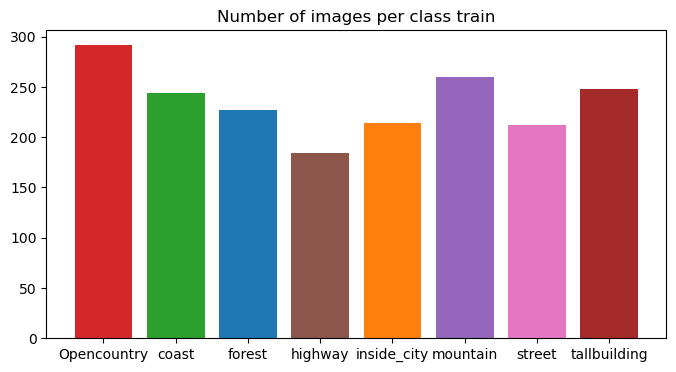

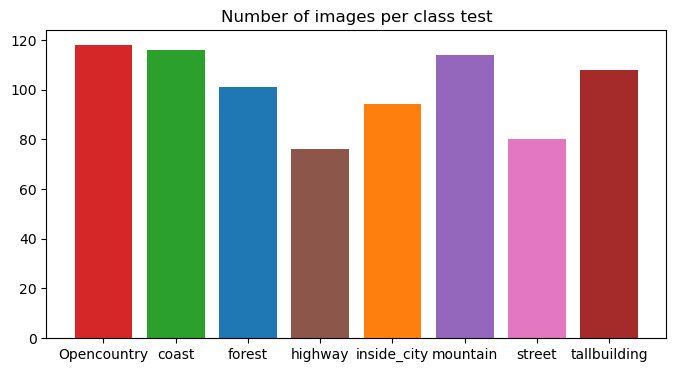

In [27]:
# Checking imbalance
# Create a bar plot counting the number of images per class
colors = ["tab:red", "tab:green", "tab:blue", "tab:brown", "tab:orange", "tab:purple", "tab:pink", "brown"]

unique, counts = np.unique(bovw.train_dataset['labels'], return_counts=True)
plt.figure(figsize=(8,4))
plt.bar(unique, counts, color=colors)
plt.title('Number of images per class train')
plt.show()

# Create a bar plot counting the number of images per class
unique, counts = np.unique(bovw.test_dataset['labels'], return_counts=True)
plt.figure(figsize=(8,4))
plt.bar(unique, counts, color=colors)
plt.title('Number of images per class test')
plt.show()


In [ ]:
lda = LinearDiscriminantAnalysis(n_components=7)
VWlda = lda.fit_transform(visual_words,train_labels)
knnlda = KNeighborsClassifier(n_neighbors=5,n_jobs=-1,metric='euclidean')
knnlda.fit(VWlda, train_labels) 
vwtestlda = lda.transform(visual_words_test)
accuracy = 100*knnlda.score(vwtestlda, test_labels)
print(accuracy)